In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib
import tqdm
import seaborn as sns

In [2]:
DATA_PATH = "./../../data/curated/"

file_names = os.listdir(DATA_PATH)
file_names = [file_name for file_name in file_names if "SGNex" in file_name]

In [3]:
predictions = {}
for file_name in tqdm.tqdm(file_names):
    df = pd.read_csv(DATA_PATH + file_name)
    df['transcript_id'] = df['transcript_id'].str.split('.').str[0]
    predictions[file_name] = df

100%|██████████████████████████████████████| 12/12 [00:20<00:00,  1.72s/it]


In [4]:
all_prim_keys = set()
for file_name in file_names:
    all_prim_keys = all_prim_keys.union(
        predictions[file_name].\
        groupby(['transcript_id','transcript_position']).\
        size().\
        reset_index().\
        drop(columns = 0).\
        itertuples(index=False, name=None))

print(len(all_prim_keys))

2879886


# Figuring out if m6A modifications occur on the same transcript ID regardless of cell line

```
for each cell line:
    for each transcript ID:
        if the transcript ID does not exist for that cell line, max score is 0
        take the maximum score across all transcript positions
```

In [5]:
all_transcripts = pd.DataFrame(sorted(list(set(item[0] for item in all_prim_keys))), columns = ["transcript_id"])
for i, k in enumerate(predictions.keys()):
    
    cell_line_name = k.split("_")[1]
    replicate_id = k.split("_")[3]
    
    cell_line_score = predictions[k].\
        groupby("transcript_id").\
        max("score").\
        reset_index().\
        loc[:, ["transcript_id", "score"]].\
        rename(columns = {"score" : cell_line_name + "_" + replicate_id + "_max_score"})

    all_transcripts = pd.merge(all_transcripts, cell_line_score, on = ["transcript_id"], how = 'outer')
    
all_transcripts = all_transcripts.fillna(0)

In [6]:
all_transcripts

,transcript_id,A549_replicate5_max_score,A549_replicate6_max_score,Hct116_replicate3_max_score_x,Hct116_replicate3_max_score_y,Hct116_replicate4_max_score,HepG2_replicate5_max_score,HepG2_replicate6_max_score,K562_replicate4_max_score,K562_replicate5_max_score,K562_replicate6_max_score,MCF7_replicate3_max_score,MCF7_replicate4_max_score
0,ENST00000000233,0.152,0.371,0.577,0.162,0.525,0.115,0.128,0.236,0.230,0.316,0.178,0.264
1,ENST00000000412,0.511,0.653,0.896,0.655,0.821,0.672,0.646,0.428,0.517,0.678,0.572,0.734
2,ENST00000000442,0.542,0.585,0.556,0.502,0.559,0.502,0.548,0.527,0.532,0.000,0.517,0.627
3,ENST00000001008,0.352,0.670,0.510,0.615,0.457,0.545,0.592,0.267,0.163,0.235,0.553,0.592
4,ENST00000001146,0.672,0.706,0.607,0.532,0.600,0.000,0.462,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88718,R2_66_1,0.000,0.000,0.459,0.000,0.000,0.000,0.000,0.263,0.456,0.000,0.000,0.611
88719,R2_66_2,0.000,0.000,0.120,0.000,0.000,0.000,0.000,0.109,0.036,0.000,0.000,0.253
88720,R2_6_2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.369,0.000,0.000,0.000,0.000
88721,R2_7_1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.474,0.000,0.000,0.000,0.000


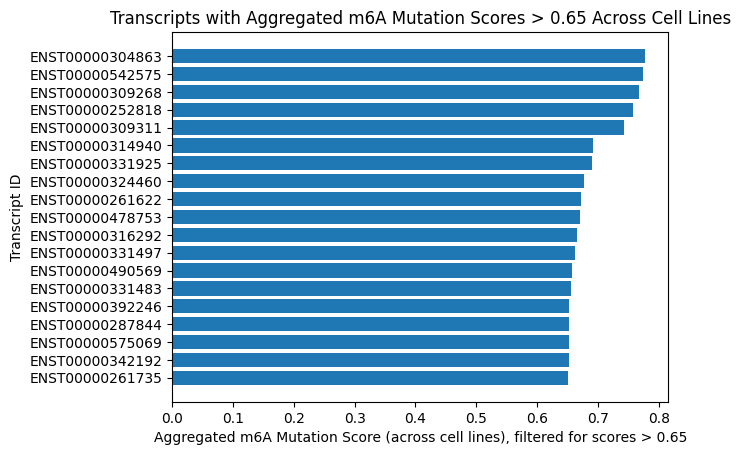

In [7]:
MIN_SCORE = 0.65
min_score_across_cell_lines = all_transcripts.set_index("transcript_id").min(axis = 1)
min_score_across_cell_lines = min_score_across_cell_lines.loc[lambda score : score > MIN_SCORE].sort_values(ascending=True)
plt.barh(min_score_across_cell_lines.index, min_score_across_cell_lines)
plt.title(f"Transcripts with Aggregated m6A Mutation Scores > {MIN_SCORE} Across Cell Lines")
plt.xlabel(f"Aggregated m6A Mutation Score (across cell lines), filtered for scores > {MIN_SCORE}")
plt.ylabel("Transcript ID")
plt.show()

These transcripts consistently exhibit high m6A mutation scores across all tested cell lines. This indicates that they can serve as reliable indicators to determine the presence or absence of cancer in any of the six cell lines.